### Initial package imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.optimize as opt
import datetime as dt
from typing import Dict, List
import random
from matplotlib.gridspec import GridSpec

In [2]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


c:\Users\Dhruv\Downloads\Master Vakken\Assignments\Quantitative Financial Risk Management\Assignment_1_FQRM\.venv\Scripts\python.exe: No module named pip


In [3]:
from statsmodels.distributions.copula.api import CopulaDistribution, GumbelCopula, ClaytonCopula, IndependenceCopula

# Validation files

In [4]:

asset_df = pd.read_csv('Data/a3/Data_assignment3.csv', sep=';')
asset_df.set_index('Date', inplace=True)
asset_df = asset_df.loc['04/01/2012':]

currency_df = asset_df[['EUR/USD', 'EUR/JPY']]
#drop na
currency_df.dropna(inplace=True)
asset_df.dropna(inplace=True)
display(currency_df.tail())
display(asset_df.head())



C:\Users\Dhruv\AppData\Local\Temp\ipykernel_6308\813508868.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currency_df.dropna(inplace=True)


,EUR/USD,EUR/JPY
Date,,
26/12/2022,1.0635,142.65
27/12/2022,1.0638,141.80
28/12/2022,1.0608,140.31
29/12/2022,1.0661,141.80
30/12/2022,1.0702,140.31


,S&P500,Dax40,Nikkei,EUR/USD,EUR/JPY,Boeing,Airbus,Volkswagen,ASML,NVIDIA,Stellantis
Date,,,,,,,,,,,
04/01/2012,1277.30,6111.55,8560.11,1.2940,99.26,74.33,24.3204,108.887,41.5584,0.3550,12.965
05/01/2012,1281.06,6095.99,8488.71,1.2780,98.64,73.53,24.3849,112.200,41.3117,0.3678,12.635
06/01/2012,1277.81,6057.92,8390.35,1.2720,97.90,73.98,24.7076,110.715,41.7013,0.3635,12.800
09/01/2012,1280.70,6017.23,8390.35,1.2765,98.05,74.53,24.5835,109.550,42.0779,0.3635,12.235
10/01/2012,1292.08,6162.98,8422.26,1.2772,98.13,75.00,24.6827,111.982,42.1818,0.3620,12.920


In [5]:
#create log returns of all columns
currency_df['EUR/USD'] = np.log(currency_df['EUR/USD'] / currency_df['EUR/USD'].shift(1))
currency_df['EUR/JPY'] = np.log(currency_df['EUR/JPY'] / currency_df['EUR/JPY'].shift(1))

#create log returns for all assets in asset_df
asset_df['R_S&P500'] = np.log(asset_df['S&P500'] / asset_df['S&P500'].shift(1))
asset_df['R_Dax40'] = np.log(asset_df['Dax40'] / asset_df['Dax40'].shift(1))
asset_df['R_Nikkei'] = np.log(asset_df['Nikkei'] / asset_df['Nikkei'].shift(1))
asset_df['R_Boeing'] = np.log(asset_df['Boeing'] / asset_df['Boeing'].shift(1))
asset_df['R_Airbus'] = np.log(asset_df['Airbus'] / asset_df['Airbus'].shift(1))
asset_df['R_Volkswagen'] = np.log(asset_df['Volkswagen'] / asset_df['Volkswagen'].shift(1))
asset_df['R_ASML'] = np.log(asset_df['ASML'] / asset_df['ASML'].shift(1))
asset_df['R_NVIDIA'] = np.log(asset_df['NVIDIA'] / asset_df['NVIDIA'].shift(1))
asset_df['R_Stellantis'] = np.log(asset_df['Stellantis'] / asset_df['Stellantis'].shift(1))

display(asset_df.head())
asset_df.dropna(inplace=True)


display(currency_df.head())
currency_df.dropna(inplace=True)


/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_57474/4272461861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currency_df['EUR/USD'] = np.log(currency_df['EUR/USD'] / currency_df['EUR/USD'].shift(1))
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_57474/4272461861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currency_df['EUR/JPY'] = np.log(currency_df['EUR/JPY'] / currency_df['EUR/JPY'].shift(1))


,S&P500,Dax40,Nikkei,EUR/USD,EUR/JPY,Boeing,Airbus,Volkswagen,ASML,NVIDIA,Stellantis,R_S&P500,R_Dax40,R_Nikkei,R_Boeing,R_Airbus,R_Volkswagen,R_ASML,R_NVIDIA,R_Stellantis
Date,,,,,,,,,,,,,,,,,,,,
04/01/2012,1277.30,6111.55,8560.11,1.2940,99.26,74.33,24.3204,108.887,41.5584,0.3550,12.965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05/01/2012,1281.06,6095.99,8488.71,1.2780,98.64,73.53,24.3849,112.200,41.3117,0.3678,12.635,0.002939,-0.002549,-0.008376,-0.010821,0.002649,0.029972,-0.005954,0.035422,-0.025783
06/01/2012,1277.81,6057.92,8390.35,1.2720,97.90,73.98,24.7076,110.715,41.7013,0.3635,12.800,-0.002540,-0.006265,-0.011655,0.006101,0.013147,-0.013324,0.009387,-0.011760,0.012974
09/01/2012,1280.70,6017.23,8390.35,1.2765,98.05,74.53,24.5835,109.550,42.0779,0.3635,12.235,0.002259,-0.006739,0.000000,0.007407,-0.005035,-0.010578,0.008990,0.000000,-0.045144
10/01/2012,1292.08,6162.98,8422.26,1.2772,98.13,75.00,24.6827,111.982,42.1818,0.3620,12.920,0.008847,0.023933,0.003796,0.006286,0.004027,0.021957,0.002466,-0.004135,0.054476


,EUR/USD,EUR/JPY
Date,,
04/01/2012,NaN,NaN
05/01/2012,-0.012442,-0.006266
06/01/2012,-0.004706,-0.007530
09/01/2012,0.003531,0.001531
10/01/2012,0.000548,0.000816


/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_57474/4272461861.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currency_df.dropna(inplace=True)


In [6]:
#corrected returns to EURO
asset_df['C_S&P500'] = (1 + asset_df['R_S&P500']) * (1 + currency_df['EUR/USD']) - 1
asset_df['C_Nikkei'] = (1 + asset_df['R_Nikkei']) * (1 + currency_df['EUR/JPY']) - 1 
asset_df['C_Dax40'] = asset_df['R_Dax40']
asset_df['C_Boeing'] = (1 + asset_df['R_Boeing']) * (1 + currency_df['EUR/USD']) - 1
asset_df['C_Airbus'] = asset_df['R_Airbus']
asset_df['C_Volkswagen'] = asset_df['R_Volkswagen']
asset_df['C_ASML'] = asset_df['R_ASML']
asset_df['C_NVIDIA'] = (1 + asset_df['R_NVIDIA']) * (1 + currency_df['EUR/USD']) - 1
asset_df['C_Stellantis'] = asset_df['R_Stellantis']
asset_df.dropna(inplace=True)
display(asset_df.head())

,S&P500,Dax40,Nikkei,EUR/USD,EUR/JPY,Boeing,Airbus,Volkswagen,ASML,NVIDIA,...,R_Stellantis,C_S&P500,C_Nikkei,C_Dax40,C_Boeing,C_Airbus,C_Volkswagen,C_ASML,C_NVIDIA,C_Stellantis
Date,,,,,,,,,,,,,,,,,,,,,
05/01/2012,1281.06,6095.99,8488.71,1.2780,98.64,73.53,24.3849,112.200,41.3117,0.3678,...,-0.025783,-0.009539,-0.014589,-0.002549,-0.023128,0.002649,0.029972,-0.005954,0.022539,-0.025783
06/01/2012,1277.81,6057.92,8390.35,1.2720,97.90,73.98,24.7076,110.715,41.7013,0.3635,...,0.012974,-0.007234,-0.019097,-0.006265,0.001367,0.013147,-0.013324,0.009387,-0.016411,0.012974
09/01/2012,1280.70,6017.23,8390.35,1.2765,98.05,74.53,24.5835,109.550,42.0779,0.3635,...,-0.045144,0.005799,0.001531,-0.006739,0.010965,-0.005035,-0.010578,0.008990,0.003531,-0.045144
10/01/2012,1292.08,6162.98,8422.26,1.2772,98.13,75.00,24.6827,111.982,42.1818,0.3620,...,0.054476,0.009400,0.004615,0.023933,0.006838,0.004027,0.021957,0.002466,-0.003589,0.054476
11/01/2012,1292.48,6152.34,8447.88,1.2703,97.64,74.74,24.8465,114.350,42.5519,0.3548,...,0.002319,-0.005109,-0.001984,-0.001728,-0.008871,0.006614,0.020926,0.008736,-0.025398,0.002319


In [7]:
bond_df = pd.read_csv('Data/a1/ECB_Data_10yr_Treasury_bond.csv', sep=',')
bond_df.drop('TIME PERIOD', axis=1, inplace=True)
bond_df['Date'] = pd.to_datetime(bond_df['Date'], format='%Y-%m-%d')
#now change the format to dd/mm/yyyy
bond_df['Date'] = bond_df['Date'].dt.strftime('%d/%m/%Y')
bond_df.set_index('Date', inplace=True)
bond_df = bond_df.loc['05/01/2012':]  # Use consistent date format
bond_df = bond_df.rename(columns={'Yield curve spot rate, 10-year maturity - Government bond': 'Bond_Yield'})
asset_df = pd.merge(asset_df, bond_df, left_index=True, right_index=True, how='left')
display(asset_df.head())

,S&P500,Dax40,Nikkei,EUR/USD,EUR/JPY,Boeing,Airbus,Volkswagen,ASML,NVIDIA,...,C_S&P500,C_Nikkei,C_Dax40,C_Boeing,C_Airbus,C_Volkswagen,C_ASML,C_NVIDIA,C_Stellantis,Bond_Yield
Date,,,,,,,,,,,,,,,,,,,,,
05/01/2012,1281.06,6095.99,8488.71,1.2780,98.64,73.53,24.3849,112.200,41.3117,0.3678,...,-0.009539,-0.014589,-0.002549,-0.023128,0.002649,0.029972,-0.005954,0.022539,-0.025783,2.784807
06/01/2012,1277.81,6057.92,8390.35,1.2720,97.90,73.98,24.7076,110.715,41.7013,0.3635,...,-0.007234,-0.019097,-0.006265,0.001367,0.013147,-0.013324,0.009387,-0.016411,0.012974,2.788371
09/01/2012,1280.70,6017.23,8390.35,1.2765,98.05,74.53,24.5835,109.550,42.0779,0.3635,...,0.005799,0.001531,-0.006739,0.010965,-0.005035,-0.010578,0.008990,0.003531,-0.045144,2.757489
10/01/2012,1292.08,6162.98,8422.26,1.2772,98.13,75.00,24.6827,111.982,42.1818,0.3620,...,0.009400,0.004615,0.023933,0.006838,0.004027,0.021957,0.002466,-0.003589,0.054476,2.746027
11/01/2012,1292.48,6152.34,8447.88,1.2703,97.64,74.74,24.8465,114.350,42.5519,0.3548,...,-0.005109,-0.001984,-0.001728,-0.008871,0.006614,0.020926,0.008736,-0.025398,0.002319,2.690639


In [8]:
	# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
daily_rates = np.zeros(len(asset_df))

# Set initial value

# Calculate bond values day by day based on the daily yield rate
for i in range(len(asset_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((asset_df['Bond_Yield'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
# Add vectors to the dataframe
asset_df['Interest_Bond_daily_rate'] = daily_rates
display(asset_df.head())

,S&P500,Dax40,Nikkei,EUR/USD,EUR/JPY,Boeing,Airbus,Volkswagen,ASML,NVIDIA,...,C_Nikkei,C_Dax40,C_Boeing,C_Airbus,C_Volkswagen,C_ASML,C_NVIDIA,C_Stellantis,Bond_Yield,Interest_Bond_daily_rate
Date,,,,,,,,,,,,,,,,,,,,,
05/01/2012,1281.06,6095.99,8488.71,1.2780,98.64,73.53,24.3849,112.200,41.3117,0.3678,...,-0.014589,-0.002549,-0.023128,0.002649,0.029972,-0.005954,0.022539,-0.025783,2.784807,0.000164
06/01/2012,1277.81,6057.92,8390.35,1.2720,97.90,73.98,24.7076,110.715,41.7013,0.3635,...,-0.019097,-0.006265,0.001367,0.013147,-0.013324,0.009387,-0.016411,0.012974,2.788371,0.000164
09/01/2012,1280.70,6017.23,8390.35,1.2765,98.05,74.53,24.5835,109.550,42.0779,0.3635,...,0.001531,-0.006739,0.010965,-0.005035,-0.010578,0.008990,0.003531,-0.045144,2.757489,0.000163
10/01/2012,1292.08,6162.98,8422.26,1.2772,98.13,75.00,24.6827,111.982,42.1818,0.3620,...,0.004615,0.023933,0.006838,0.004027,0.021957,0.002466,-0.003589,0.054476,2.746027,0.000163
11/01/2012,1292.48,6152.34,8447.88,1.2703,97.64,74.74,24.8465,114.350,42.5519,0.3548,...,-0.001984,-0.001728,-0.008871,0.006614,0.020926,0.008736,-0.025398,0.002319,2.690639,0.000161


# Copulas

For the return pairs we have chosen the following:

- Boeing and Airbus
- ASML and NVIDIA
- Volkswagen and Stellantis 


### Fit appropriate marginal distributions

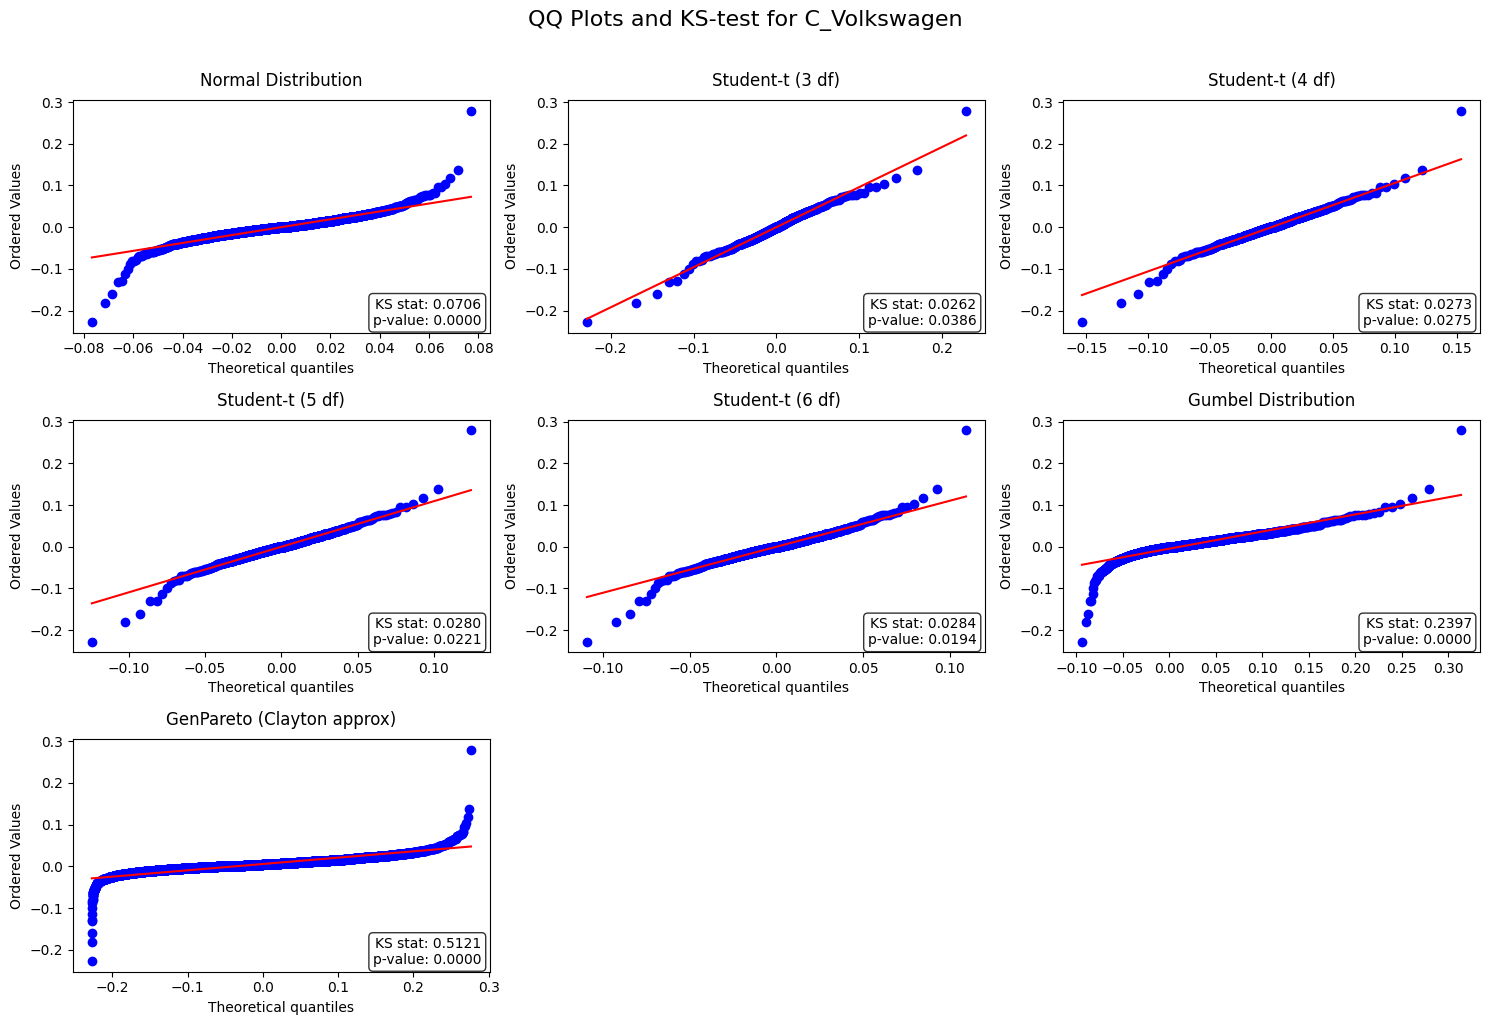

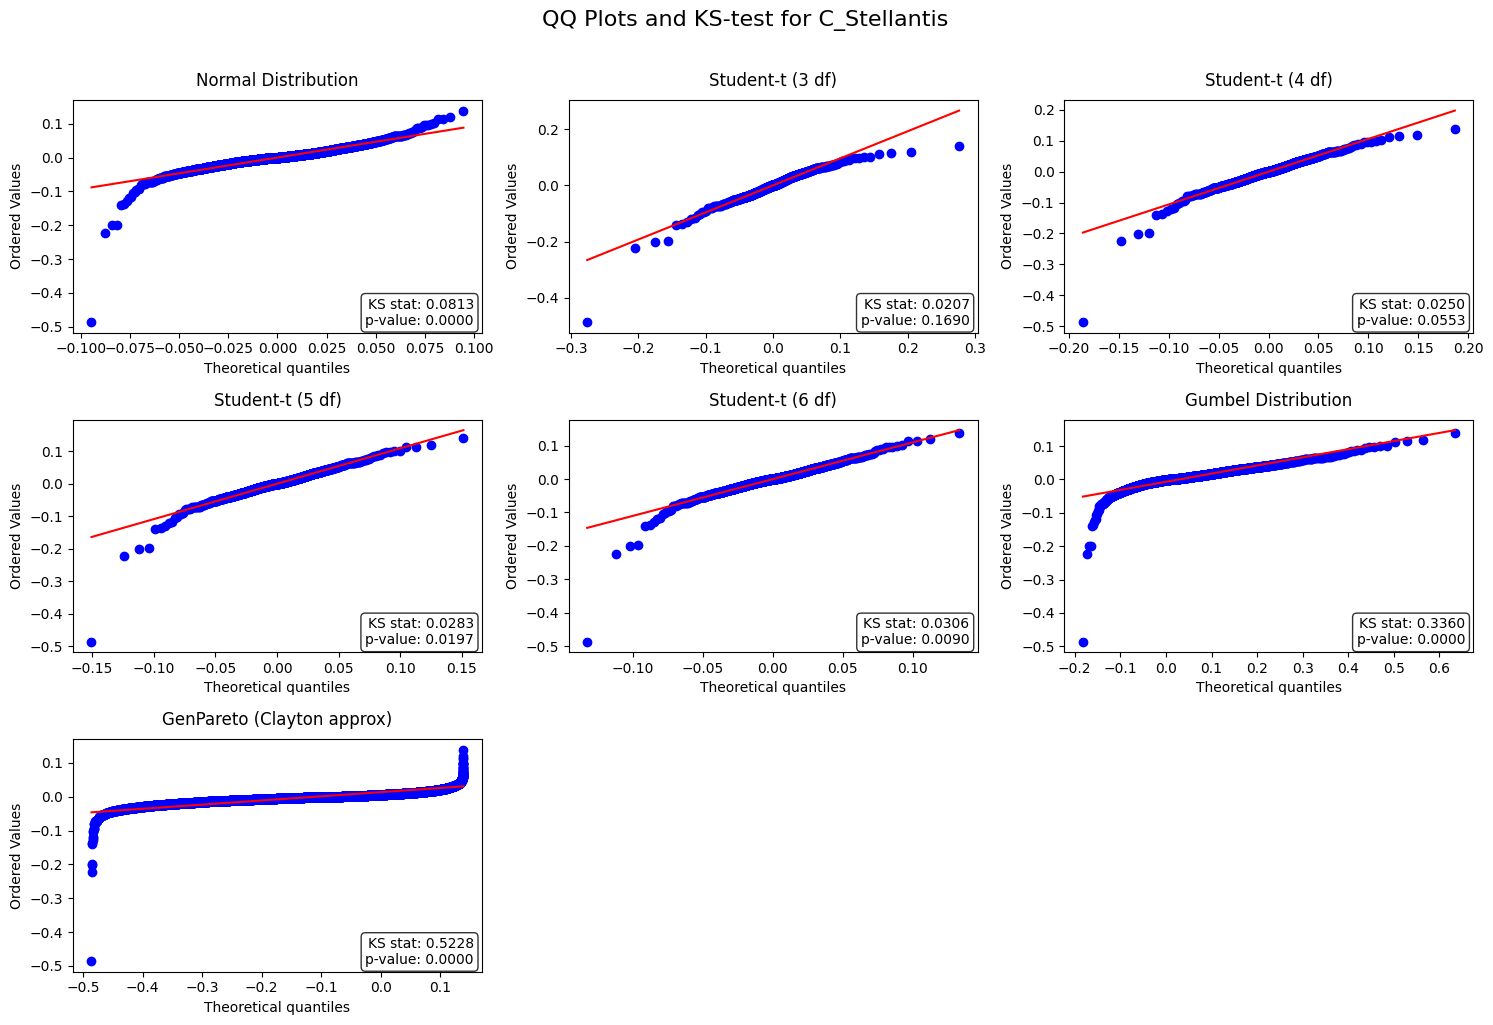

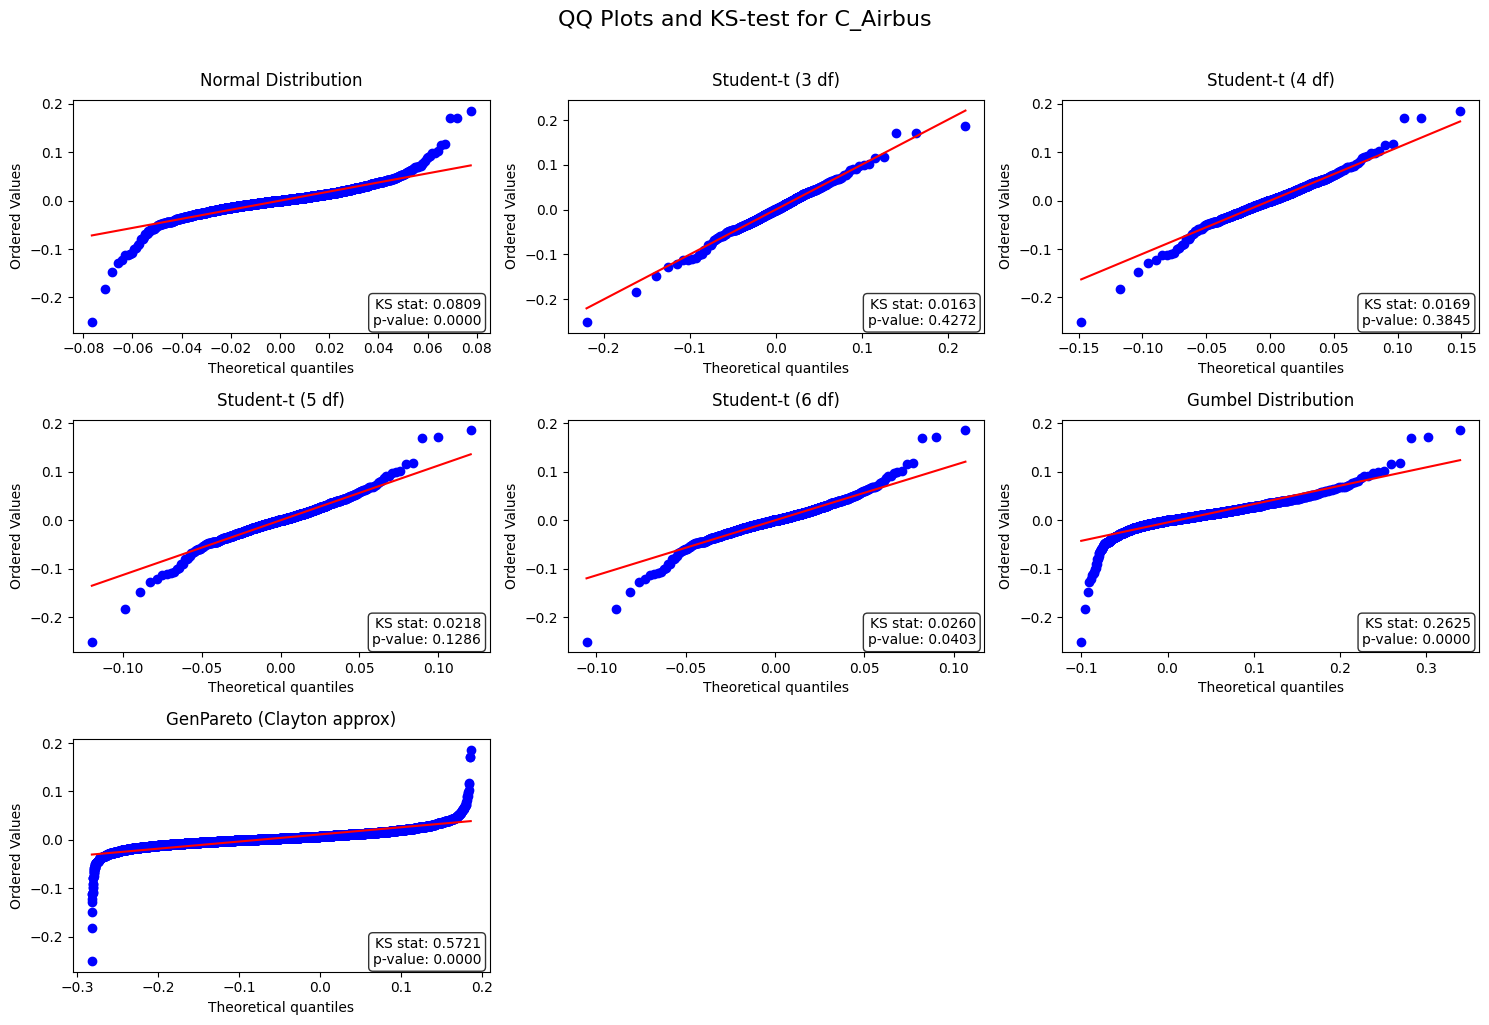

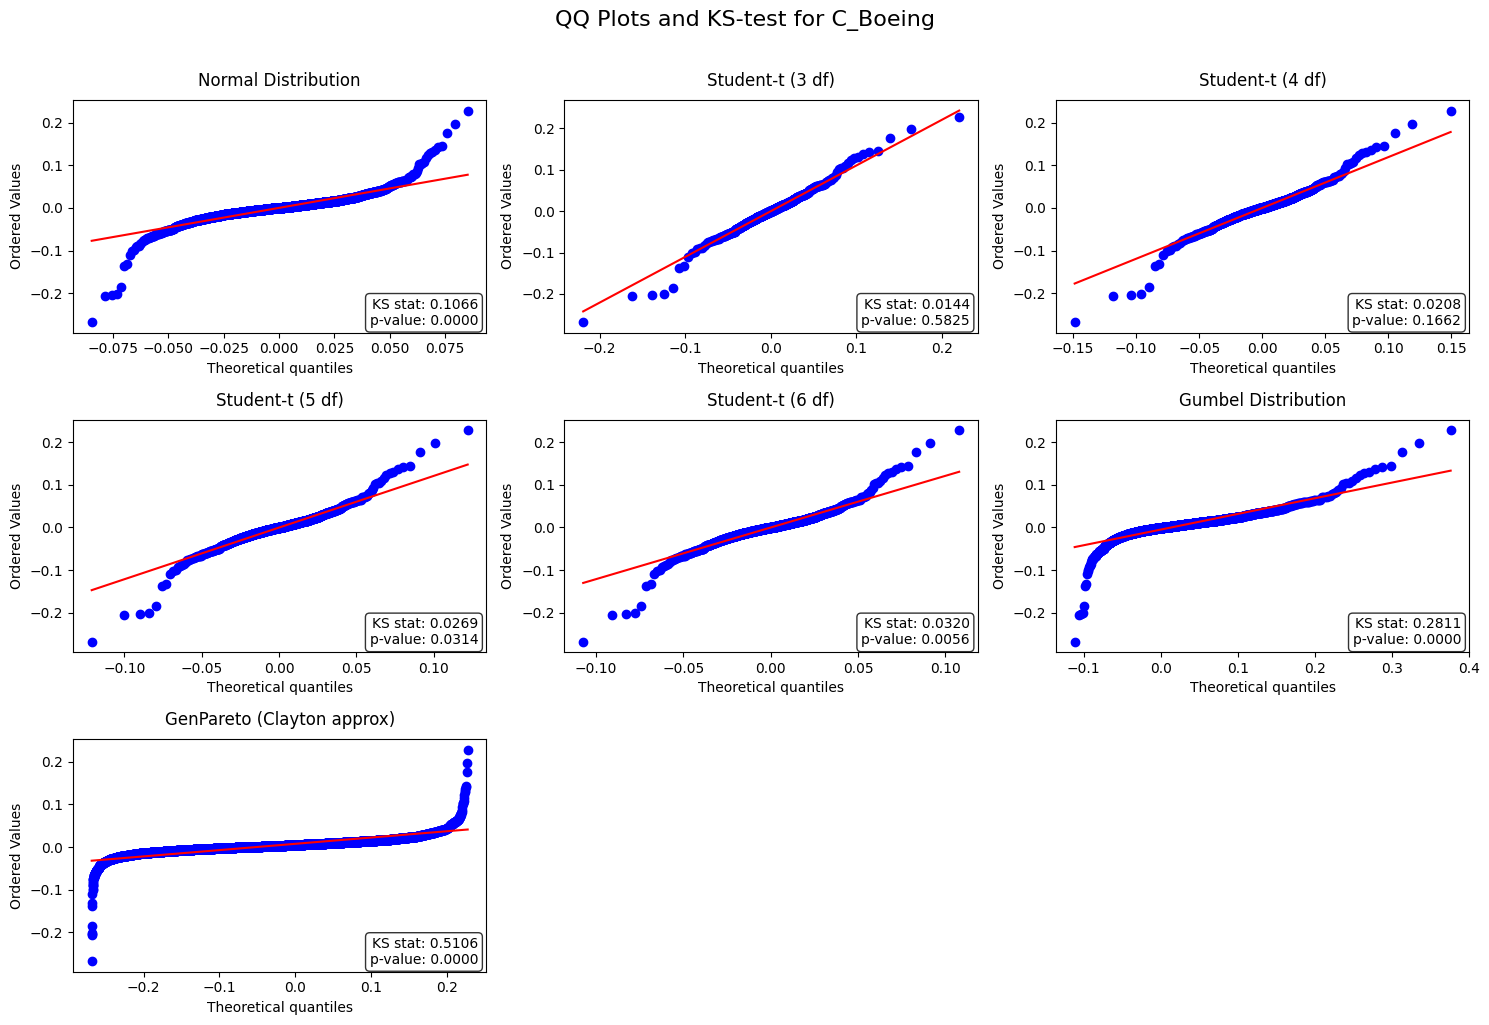

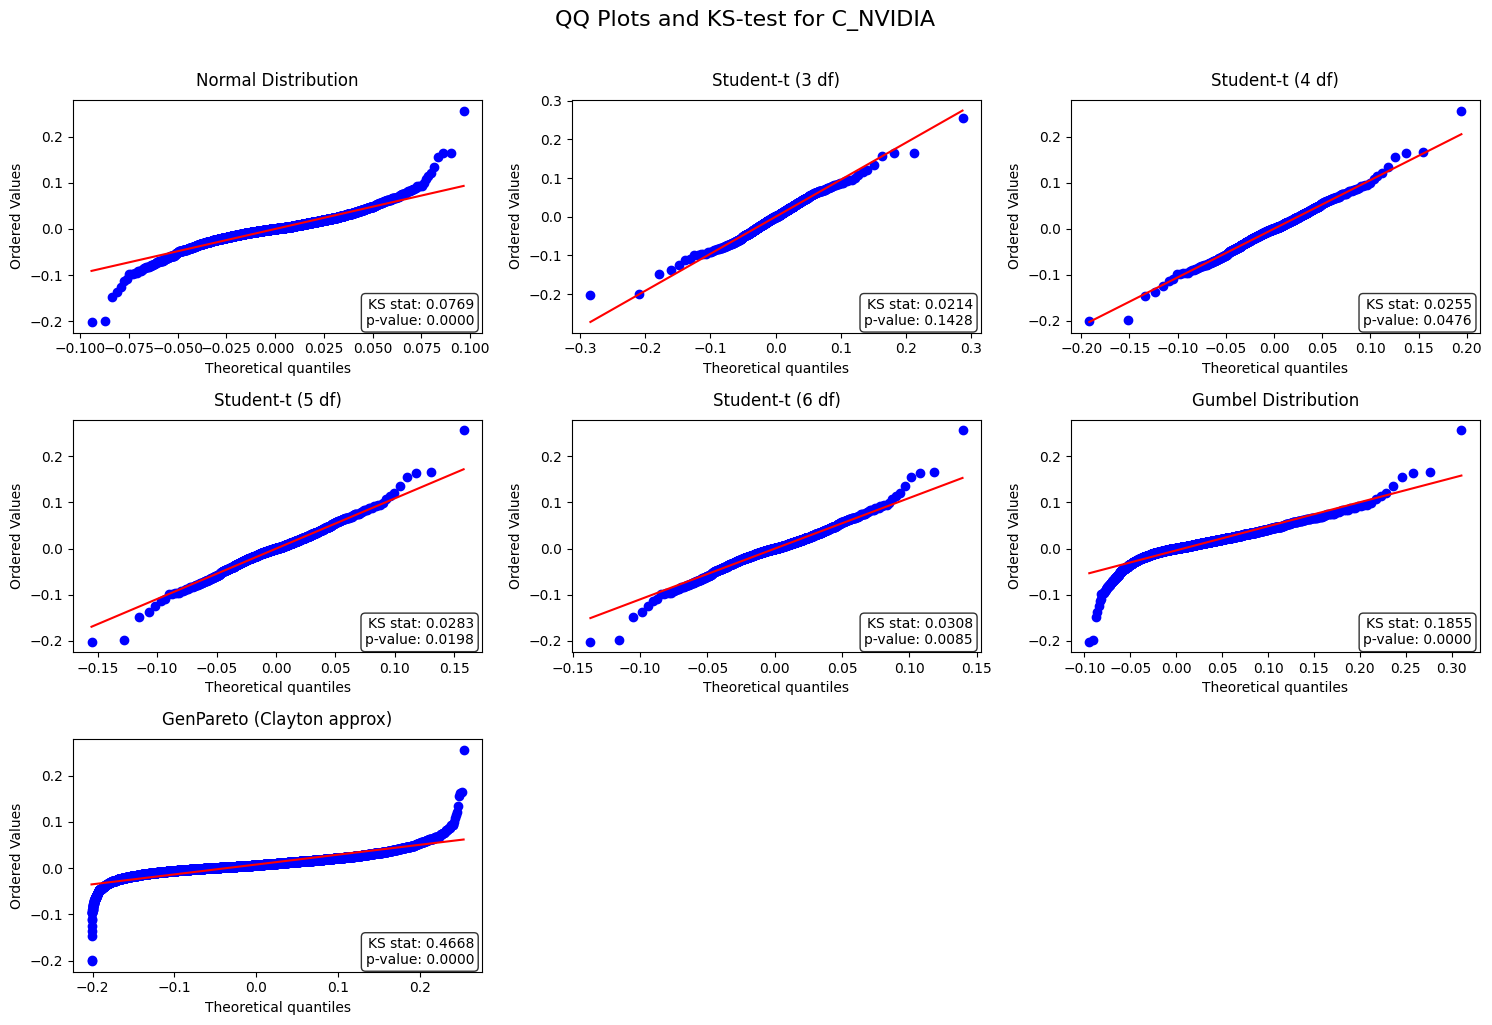

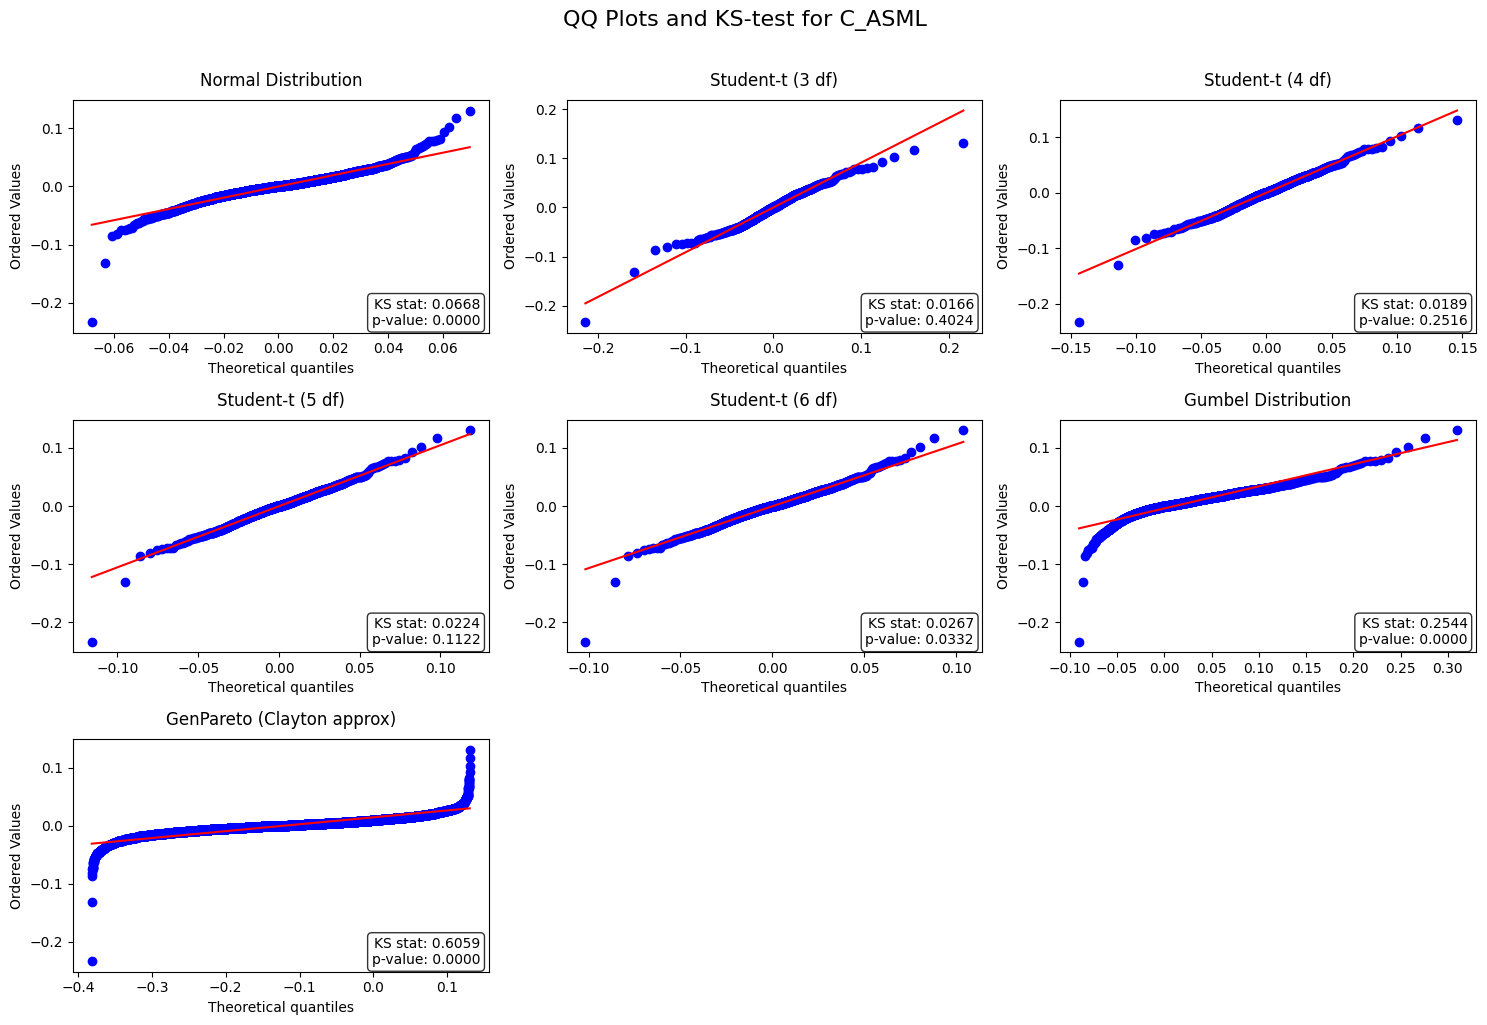

In [9]:
for asset in ['C_Volkswagen', 'C_Stellantis', 'C_Airbus', 'C_Boeing', 'C_NVIDIA', 'C_ASML']:
    fig = plt.figure(figsize=(15, 10))
    plt.suptitle(f'QQ Plots and KS-test for {asset}', fontsize=16, y=1.02)
    
    data = asset_df[asset]

    distributions = [
        (st.norm, 'Normal Distribution', ()),
        (st.t, 'Student-t (3 df)', (3,)),
        (st.t, 'Student-t (4 df)', (4,)),
        (st.t, 'Student-t (5 df)', (5,)),
        (st.t, 'Student-t (6 df)', (6,)),
        (st.gumbel_r, 'Gumbel Distribution', ()),
        (st.genpareto, 'GenPareto (Clayton approx)', ())
    ]
    
    for idx, (dist, title, shape_param) in enumerate(distributions, 1):
        ax = plt.subplot(3, 3, idx)

        if shape_param:
            loc, scale = st.t.fit(data, f0=shape_param[0])[1:]
            sparams = (shape_param[0], loc, scale)
        else:
            params = dist.fit(data)
            sparams = params

        ks_stat, p_value = st.kstest(data, dist.name, args=sparams)

        st.probplot(data, dist=dist, sparams=sparams, plot=plt)
        plt.title(title, pad=10)

        text = f'KS stat: {ks_stat:.4f}\np-value: {p_value:.4f}'
        plt.text(0.98, 0.02, text, transform=ax.transAxes,
                 verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()


In [10]:
#create seperate dataframes for each couples with date and closing prices 
df_pair1 = asset_df[['C_Volkswagen','C_Stellantis']]
df_pair2 = asset_df[['C_Airbus','C_Boeing']]
df_pair3 = asset_df[['C_NVIDIA','C_ASML']]

display(df_pair1.head())
display(df_pair2.head())
display(df_pair3.head())

,C_Volkswagen,C_Stellantis
Date,,
05/01/2012,0.029972,-0.025783
06/01/2012,-0.013324,0.012974
09/01/2012,-0.010578,-0.045144
10/01/2012,0.021957,0.054476
11/01/2012,0.020926,0.002319


,C_Airbus,C_Boeing
Date,,
05/01/2012,0.002649,-0.023128
06/01/2012,0.013147,0.001367
09/01/2012,-0.005035,0.010965
10/01/2012,0.004027,0.006838
11/01/2012,0.006614,-0.008871


,C_NVIDIA,C_ASML
Date,,
05/01/2012,0.022539,-0.005954
06/01/2012,-0.016411,0.009387
09/01/2012,0.003531,0.008990
10/01/2012,-0.003589,0.002466
11/01/2012,-0.025398,0.008736


In [23]:
from scipy.stats import t, gumbel_r, genpareto

# For each column in df_pair1
data_vw = np.array(df_pair1['C_Volkswagen'])
data_st = np.array(df_pair1['C_Stellantis'])

# For each column in df_pair2
data_air = np.array(df_pair2['C_Airbus'])
data_boe = np.array(df_pair2['C_Boeing'])

# For each column in df_pair3
data_nv = np.array(df_pair3['C_NVIDIA'])
data_asml = np.array(df_pair3['C_ASML'])

# Dictionary to store uniform transformations for each distribution
uniform_data_t = {}      # Student-t
uniform_data_gumbel = {} # Gumbel
uniform_data_clayton = {} # Clayton (using GenPareto)

# Lists of pairs to process
pairs = [
    (data_vw, data_st, 'Volkswagen', 'Stellantis'),
    (data_air, data_boe, 'Airbus', 'Boeing'),
    (data_nv, data_asml, 'NVIDIA', 'ASML')
]

for pair in pairs:
    data1, data2, name1, name2 = pair
    
    # Student-t (df = 3)
    df_fixed = 3
    loc1_t, scale1_t = np.mean(data1), np.std(data1, ddof=1)
    loc2_t, scale2_t = np.mean(data2), np.std(data2, ddof=1)
    uniform_data_t[name1] = t.cdf(data1, df_fixed, loc=loc1_t, scale=scale1_t)
    uniform_data_t[name2] = t.cdf(data2, df_fixed, loc=loc2_t, scale=scale2_t)
    
    # Gumbel
    params1_gumbel = gumbel_r.fit(data1)
    params2_gumbel = gumbel_r.fit(data2)
    uniform_data_gumbel[name1] = gumbel_r.cdf(data1, *params1_gumbel)
    uniform_data_gumbel[name2] = gumbel_r.cdf(data2, *params2_gumbel)
    
    # Clayton (using GenPareto)
    params1_clayton = genpareto.fit(data1)
    params2_clayton = genpareto.fit(data2)
    uniform_data_clayton[name1] = genpareto.cdf(data1, *params1_clayton)
    uniform_data_clayton[name2] = genpareto.cdf(data2, *params2_clayton)

# Set the default transformation to Student-t for consistency with the next cell


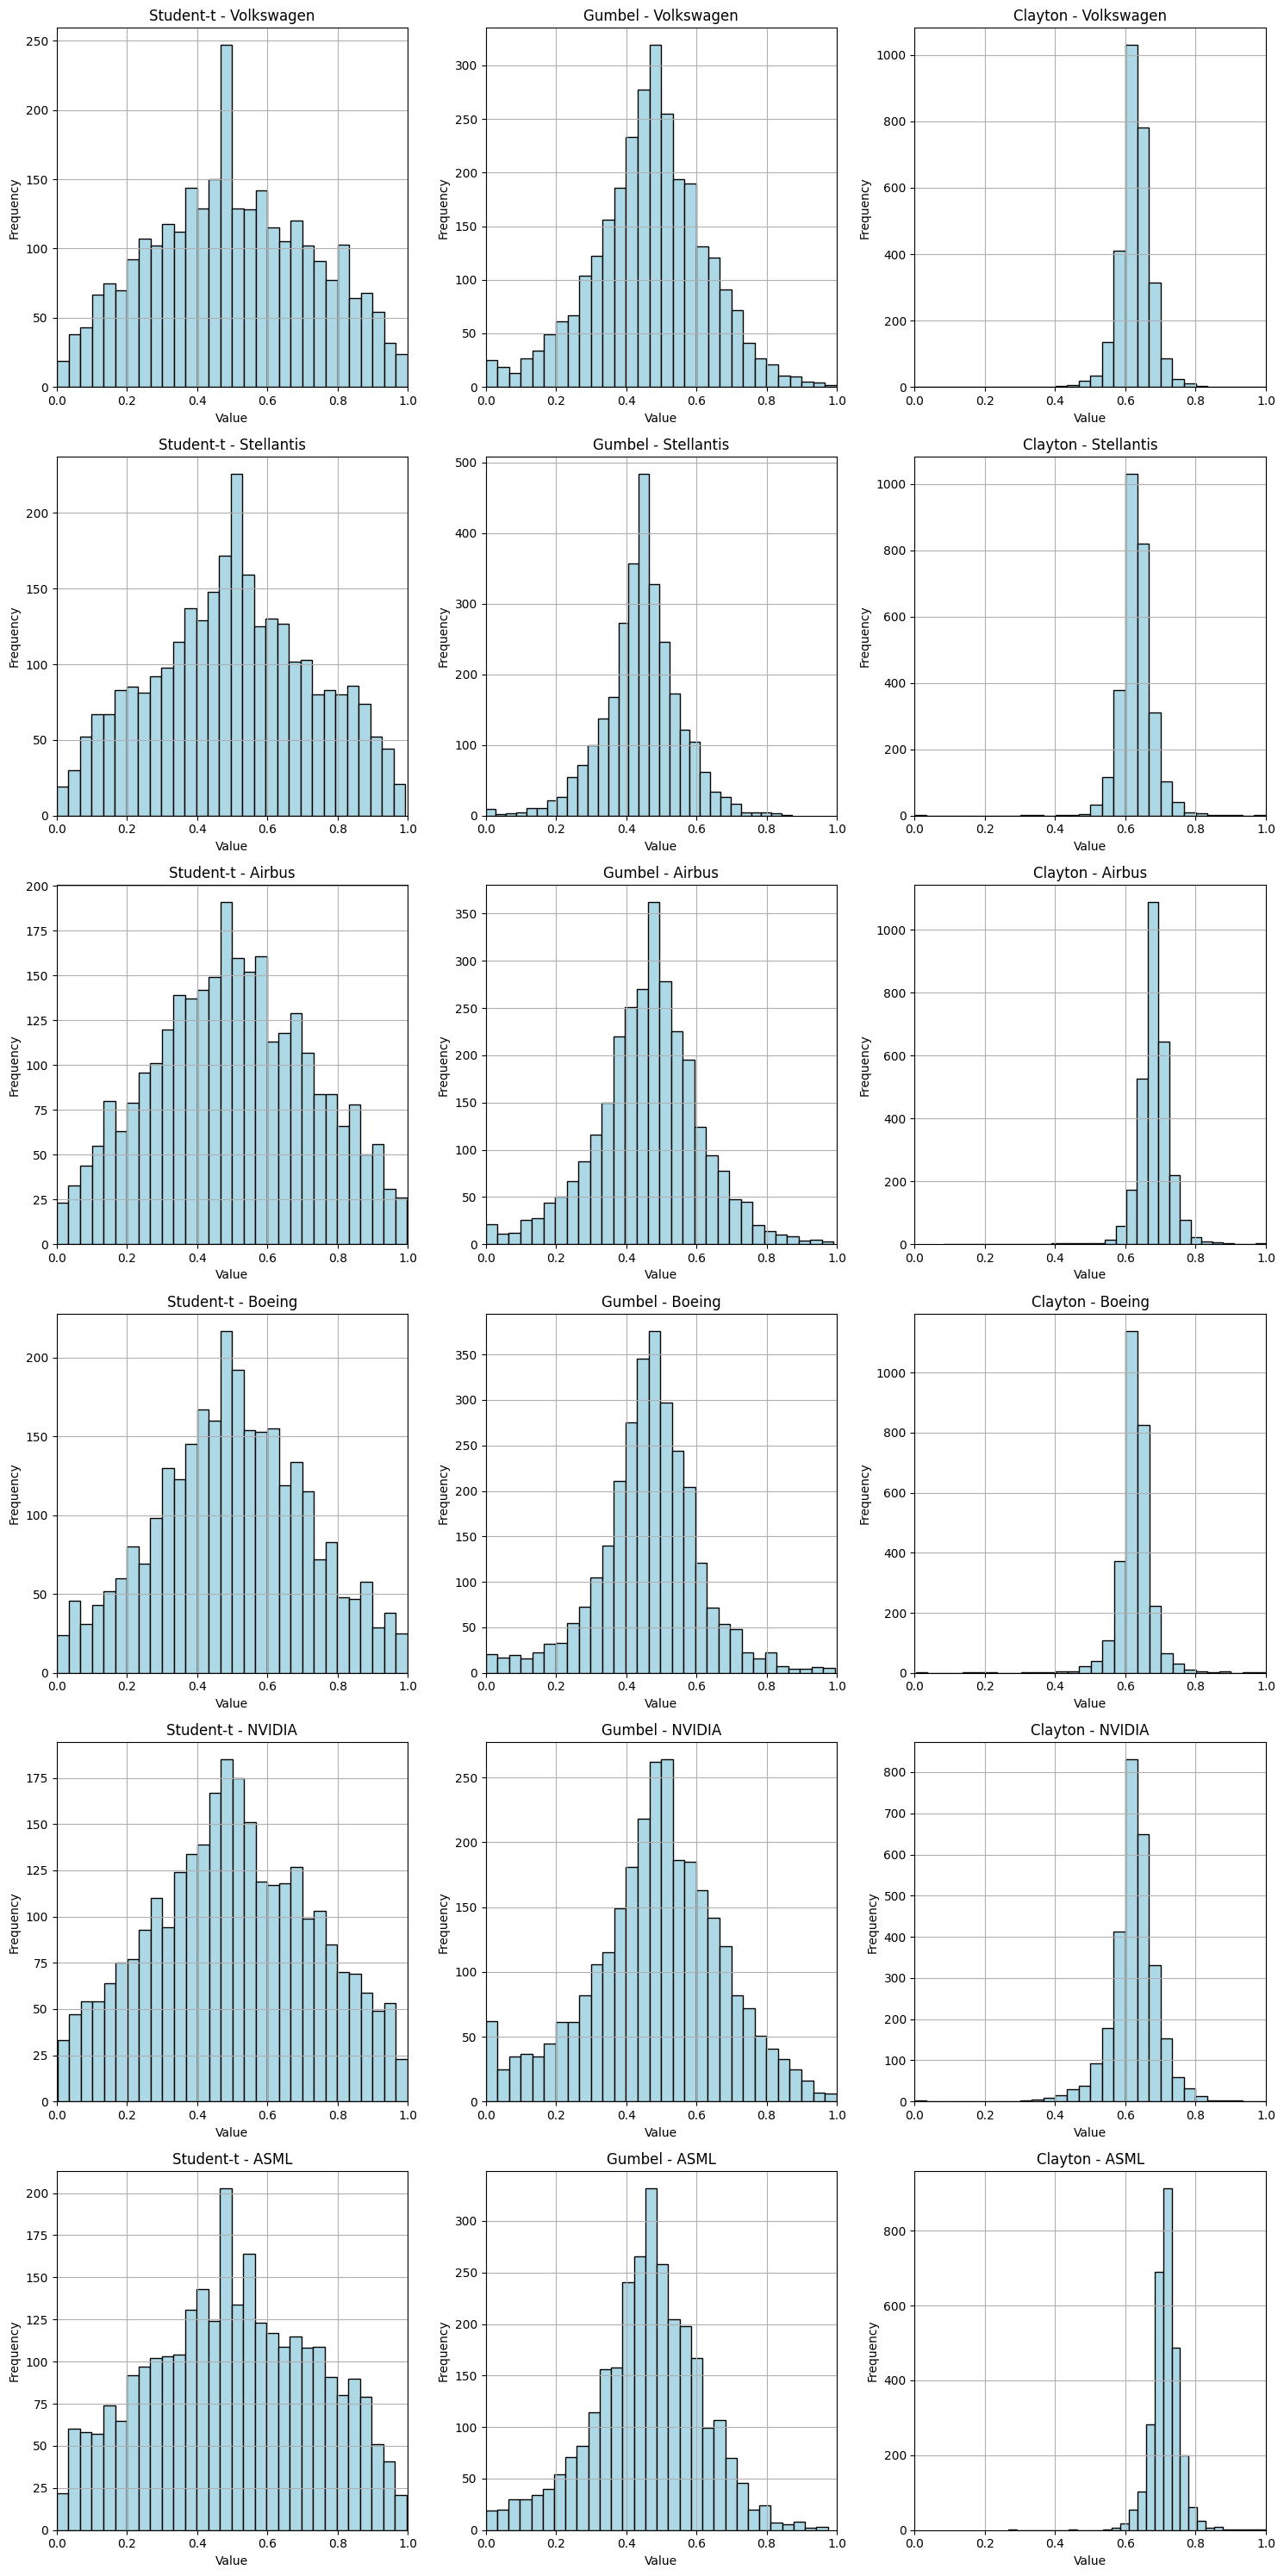

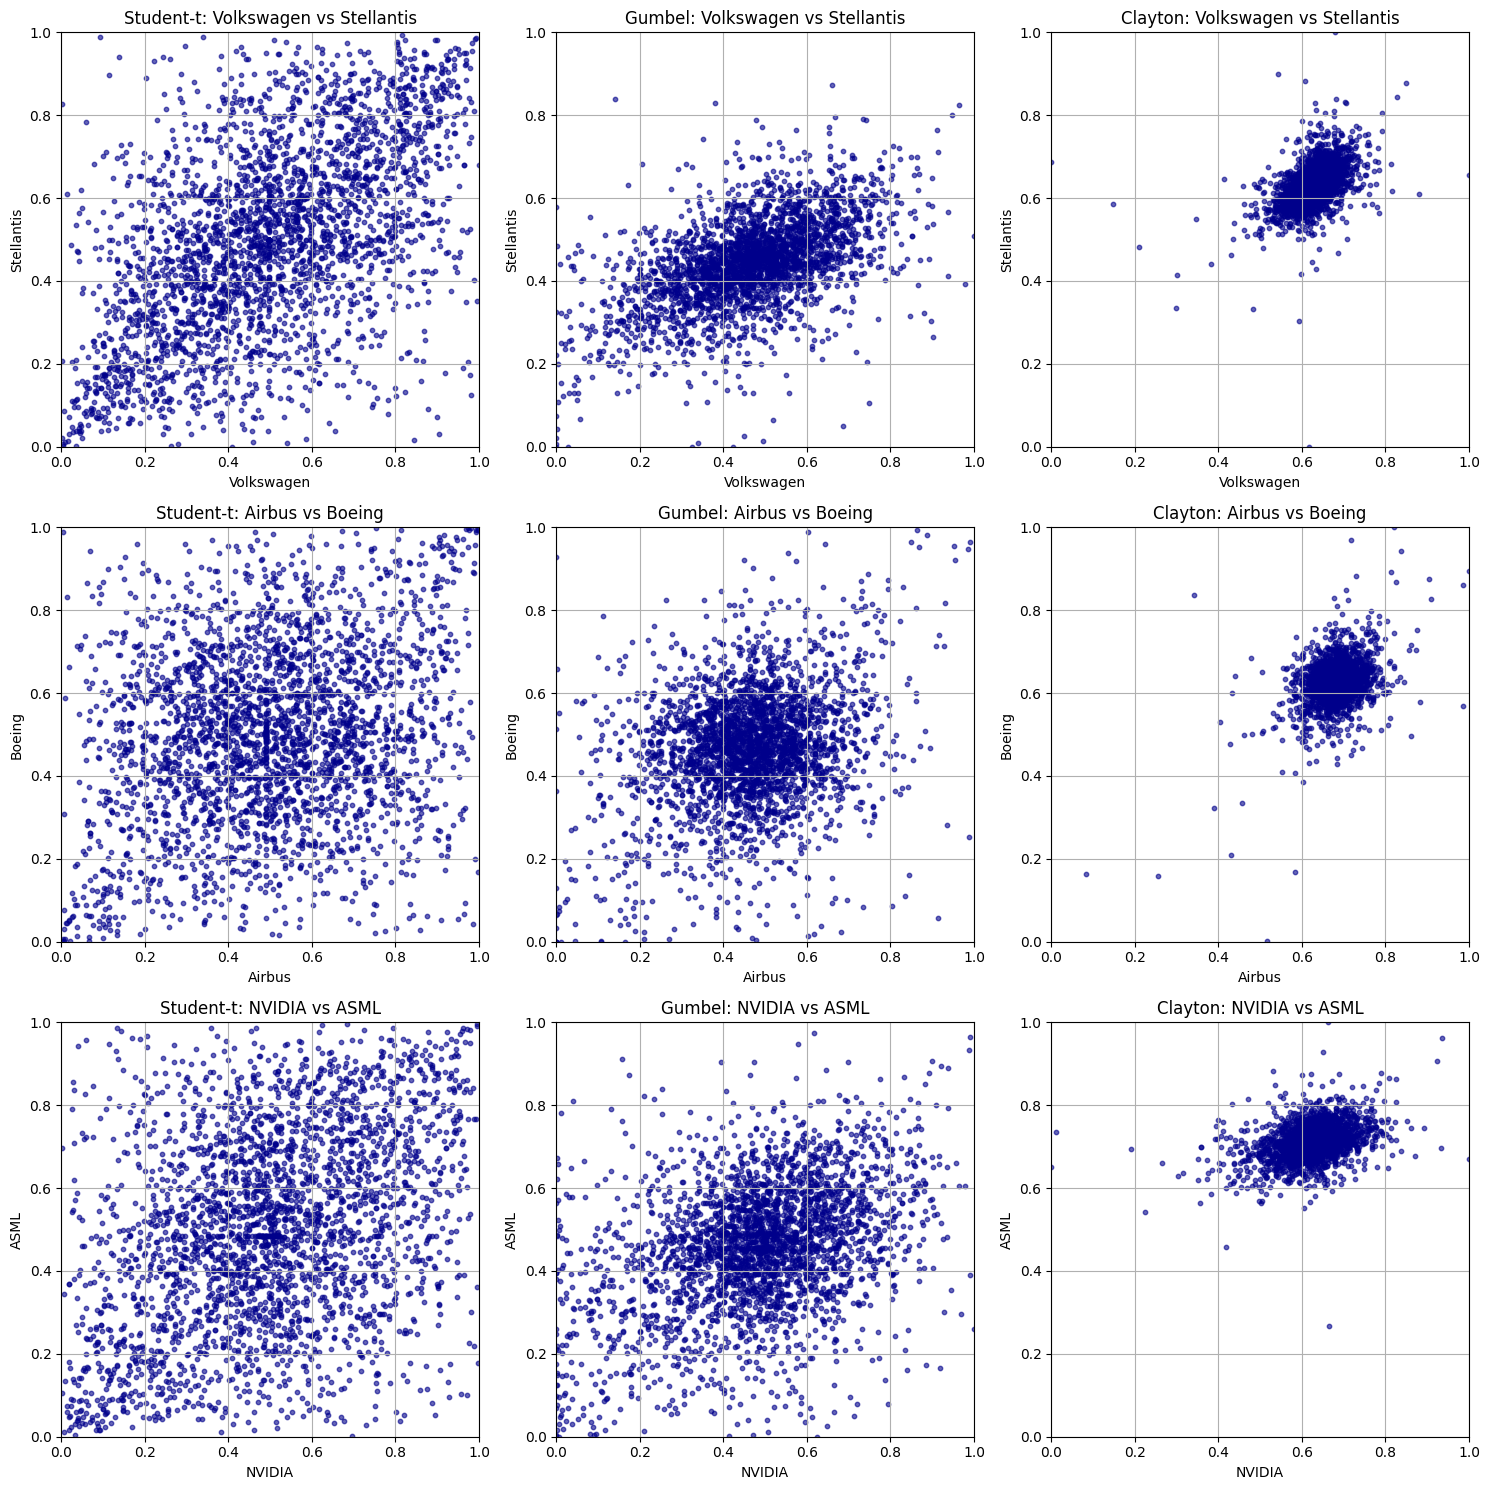

In [24]:
# Create subplots for each distribution type
fig = plt.figure(figsize=(15, 30))
gs = GridSpec(6, 3, figure=fig)

assets = ['Volkswagen', 'Stellantis', 'Airbus', 'Boeing', 'NVIDIA', 'ASML']


# Distribution names
dist_names = ['Student-t', 'Gumbel', 'Clayton']
dist_data = [uniform_data_t, uniform_data_gumbel, uniform_data_clayton]

# Plot for each distribution type
for dist_idx, (dist_name, dist) in enumerate(zip(dist_names, dist_data)):
    # 1. Histograms
    for i, asset in enumerate(assets):
        ax = fig.add_subplot(gs[i, dist_idx])
        ax.hist(dist[asset], bins=30, color='lightblue', edgecolor='black')
        ax.set_title(f"{dist_name} - {asset}")
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.set_xlim(0, 1)
        ax.grid(True)

plt.tight_layout()
plt.show()

# Scatter plots for each pair and distribution
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(3, 3, figure=fig)

pairs = [
    ('Volkswagen', 'Stellantis'),
    ('Airbus', 'Boeing'),
    ('NVIDIA', 'ASML')
]

for dist_idx, (dist_name, dist) in enumerate(zip(dist_names, dist_data)):
    for pair_idx, (a1, a2) in enumerate(pairs):
        ax = fig.add_subplot(gs[pair_idx, dist_idx])
        ax.scatter(dist[a1], dist[a2], alpha=0.6, color='darkblue', s=10)
        ax.set_xlabel(a1)
        ax.set_ylabel(a2)
        ax.set_title(f"{dist_name}: {a1} vs {a2}")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True)

plt.tight_layout()
plt.show()


In [16]:
pip install copulas 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 6.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
from copulas.multivariate import GaussianMultivariate
from scipy.stats import uniform
import numpy as np
import matplotlib.pyplot as plt

results = []

# Define asset pairs
pairs = [
    ('Volkswagen', 'Stellantis'),
    ('Airbus', 'Boeing'),
    ('NVIDIA', 'ASML')
]

# Define copula configurations
copula_configs = {
    'Gaussian': GaussianMultivariate,
    # 'Student-t': StudentMultivariate
}

for name1, name2 in pairs:
    print(f"\n🔍 Pair: {name1} vs {name2}")
    u = uniform_data_t[name1]
    v = uniform_data_t[name2]
    uv = np.column_stack((u, v))

    pair_results = {'Pair': f'{name1} vs {name2}'}

    for copula_name, copula_class in copula_configs.items():
        copula = copula_class()
        copula.fit(uv)
        loglik = copula.log_likelihood(uv)
        params = copula.to_dict()

        print(f"  {copula_name:<12} | Log-Likelihood = {loglik:.2f}")
        pair_results[copula_name] = {
            'params': params,
            'loglik': loglik,
            'copula_obj': copula
        }

    results.append(pair_results)

# 🔍 Plot samples from best-fitting copula for each pair
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, pair_result in enumerate(results):
    name1, name2 = pairs[i]
    best_copula_name = max(
        ['Gaussian', 'Student-t'],
        key=lambda k: pair_result[k]['loglik']
    )
    copula = pair_result[best_copula_name]['copula_obj']
    samples = copula.sample(1000)

    ax = axes[i]
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
    ax.set_title(f"{pair_result['Pair']}\nBest: {best_copula_name}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True)

plt.suptitle("Samples from Best-Fitting Copula per Pair", fontsize=16)
plt.tight_layout()
plt.show()



🔍 Pair: Volkswagen vs Stellantis


AttributeError: 'GaussianMultivariate' object has no attribute 'log_likelihood'